# K-Nearest Neighbors for Regression

Linear regression is not the only machine learning model that Ashenfelter could have fit.

In [98]:
import pandas as pd
import numpy as np


bordeaux_df = pd.read_csv("bordeaux.csv",
                          index_col="year")

# Split the data into training and test sets.
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_test = bordeaux_df.loc[1981:].copy()

# Log transform the target.
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])
bordeaux_train.head()

,price,summer,har,sep,win,age,log(price)
year,,,,,,,
1952,37.0,17.1,160,14.3,600,40,3.610918
1953,63.0,16.7,80,17.3,690,39,4.143135
1955,45.0,17.1,130,16.8,502,37,3.806662
1957,22.0,16.1,110,16.2,420,35,3.091042
1958,18.0,16.4,187,19.1,582,34,2.890372


Let's focus on just two features for now: winter rainfall (**win**) and average summer temperature (**summer**). Let's plot the training data, using a color gradient to represent the target (**log(price)**). Notice how we can customize the color gradient using the `cmap=` argument. A list of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).

<AxesSubplot:xlabel='win', ylabel='summer'>

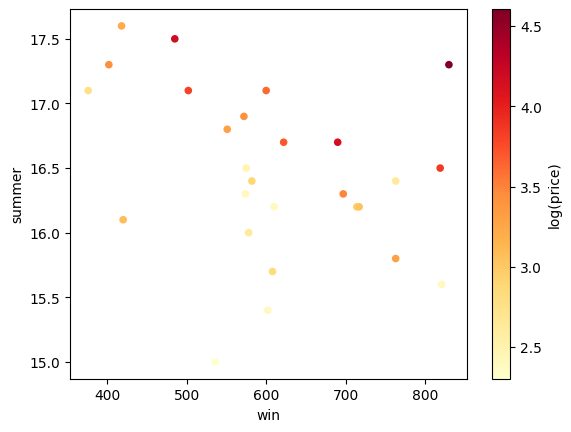

In [99]:
import matplotlib.cm as cm

bordeaux_train.plot.scatter(x="win", y="summer", c="log(price)", 
                            cmap=cm.YlOrRd)

Notice how wines that are close on this scatterplot are of similar quality. This insight is the basis of the $k$-nearest neighbors algorithm for predicting wine quality. Suppose that we want to predict the quality of the 1986 vintage, represented by a blue star in the plot below. 

![](regression_neighbors.png)

The $k=5$ points that are closest to this point in feature space are indicated by dotted lines. We can average the qualities of thse wines to obtain our prediction. All 5 of these points have a quality less than 3.0, so the 1986 vintage is also predicted to be of low quality.

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features.
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

Let's implement this in code. First, we extract the training data and scale the features:

In [100]:
X_train = bordeaux_train[["win", "summer"]]
y_train = bordeaux_train["log(price)"]

# Standardize the features.
X_train_mean = X_train.mean()
X_train_sd = X_train.std()
X_train_st = (X_train - X_train_mean) / X_train_sd

Now, we get the features for the new observation (i.e., the 1986 vintage), standardizing it in the same way.

In [101]:
x_new = bordeaux_test.loc[1986, ["win", "summer"]]

x_new_st = (x_new - X_train_mean) / X_train_sd
x_new_st

win      -0.351900
summer   -0.261262
dtype: float64

Now we calculate the (Euclidean) distances between the 1986 vintage and the vintages in the training data.

In [102]:
dists = np.sqrt(((X_train_st - x_new_st) ** 2).sum(axis=1))
dists

year
1952    1.259860
1953    1.159726
1955    1.314727
1957    1.149883
1958    0.212597
1959    1.936933
1960    1.557535
1961    2.575503
1962    1.038478
1963    0.983970
1964    1.976971
1965    1.412851
1966    2.007525
1967    1.180230
1968    0.395207
1969    0.320488
1970    0.765065
1971    0.772366
1972    2.004492
1973    1.898753
1974    0.085248
1975    0.922736
1976    2.288442
1977    2.269387
1978    1.729248
1979    1.203287
1980    0.474508
dtype: float64

Now, we sort the distances. The first 5 of these are the nearest neighbors. To get the year of these nearest neighbors, we get the index.

In [103]:
i_nearest = dists.sort_values().index[:5]
i_nearest

Int64Index([1974, 1958, 1969, 1968, 1980], dtype='int64', name='year')

We can look up these years in the training data.

In [104]:
bordeaux_train.loc[i_nearest]

,price,summer,har,sep,win,age,log(price)
year,,,,,,,
1974,11.0,16.3,184,16.2,574,18,2.397895
1958,18.0,16.4,187,19.1,582,34,2.890372
1969,12.0,16.5,244,16.6,575,23,2.484907
1968,11.0,16.2,292,16.4,610,24,2.397895
1980,14.0,16.0,74,18.4,578,12,2.639057


To make a prediction for the price of the 1986 vintage, we average the sale prices of these 5-nearest neighbors.

In [105]:
y_train.loc[i_nearest].mean()

2.562025256579233

So the model predicts that the quality of the 1986 is about 2.56, which is well below the average quality.

Of course, the model above only had two features so it was easy to visualize the "nearest neighbors" on the scatterplot. The magic of $k$-nearest neighbors is that it still works when there are more features and the data is not possible to visualize.

## K-Nearest Neighbors in scikit-learn

Now let's see how to implement $k$-nearest neighbors in scikit-learn. Recall from the previous lesson that all scikit-learn models follow the three-step pattern:

1. Declare the model.
2. Fit the model to training data.
3. Use the model to predict on test data.

To fit a $k$-nearest neighbors model instead of a linear regression model, we only need to modify the first step. Instead of declaring a model of type `LinearRegression`, we define a model of type `KNeighborsRegressor`, specifying the value of $k$ as one of the parameters. Because `KNeighborsRegressor` works with distances, it is a good idea to scale the features before passing the features into the model. (Refer back to Chapter 3 for a full explanation.)

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Standardize the training and test data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_new_st = scaler.transform(pd.DataFrame([x_new])) # needs to be a DataFrame
y_train = bordeaux_train["log(price)"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X=X_train_st, y=y_train)
model.predict(X=X_new_st)

array([2.56202526])

This is the same predicted value that we got by implementing $k$-nearest neighbors manually.

In the code above, we had to be careful to standardize the training data and the test data in exactly the same way before fitting the $k$-nearest neighbors model. Most machine learning models have many more preprocessing steps. As the preprocessing gets more complex, it is easy to accidentally omit one of the preprocessing steps. For this reason, scikit-learn provides a _Pipeline_ object, which simply chains together a sequence of preprocessing and model building steps. If we call `Pipeline.fit()` or `Pipeline.predict()` on the data, all of the steps will be applied to the data in a consistent manner.

In [107]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=5)
)

pipeline.fit(X=X_train, y=y_train)
pipeline.predict(X=pd.DataFrame([x_new]))

array([2.56202526])

## The K-Nearest Neighbors Regression Function

A predictive model is simply a function $f$ that maps feature values ${\bf x}$ to target values $y$. We can visualize $f$ when ${\bf x}$ consists of just a single feature, such as **age**. In the previous lesson, we saw that $f$ is just a line when the model is linear regression. What does $f$ look like when the model is a $k$-nearest neighbors regressor?

First, we extract the training data. There is no need to scale the features in this case because there is only one feature. (The point of scaling is to bring all of the variables to the same scale.

In [108]:
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

Now we fit the $k$-nearest neighbor model as before. We do not need to standardize the feature in this case because there is only one feature. Standardizing is only useful when there are multiple features that we want to bring to the same scale.

In [109]:
# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X=X_train, y=y_train)

KNeighborsRegressor()

In order to graph $f$, we need to evaluate the predictive model at a grid of feature values. Since age ranges from 12 to 40 in the training data, we create a grid of ${\bf x}$ values from 10 to 45, make predictions at these values, and plot these predictions as a curve.

<AxesSubplot:xlabel='age', ylabel='log(price)'>

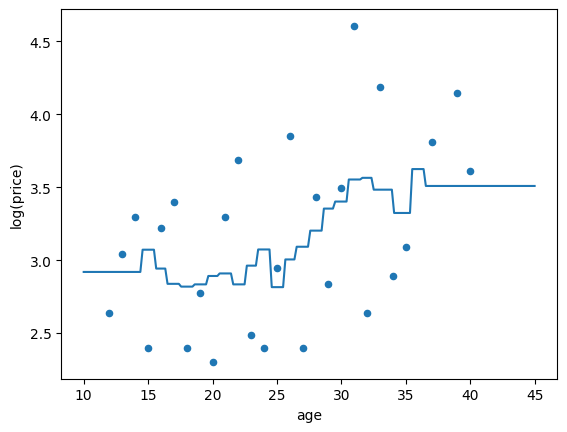

In [110]:
# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=200)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the predictions.
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

Unlike the linear regression model, the $k$-nearest neighbor model is piecewise constant. For example, wines more than 37 years old all have the same 5-nearest neighbors, so the prediction is constant in that range.

# Exercises

1\. Plot the $k$-nearest neighbors regression function for predicting the quality of a wine from its age for $k=1, 5, 10, 20$. How does the regression function change as $k$ increases?

<AxesSubplot:xlabel='age', ylabel='log(price)'>

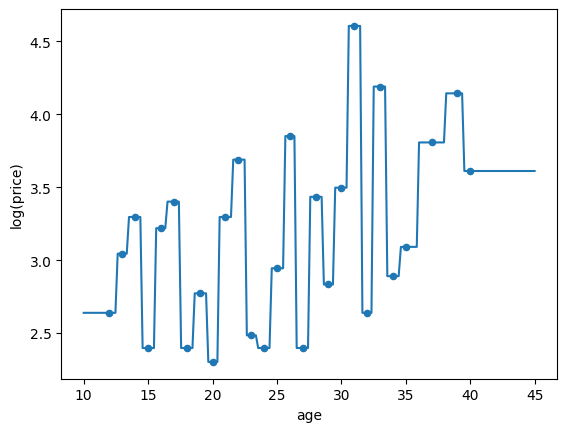

In [115]:
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X=X_train, y=y_train)

# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=200)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the predictions.
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

<AxesSubplot:xlabel='age', ylabel='log(price)'>

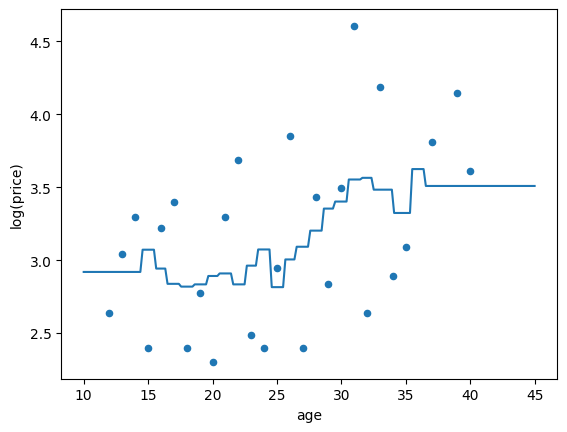

In [114]:
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X=X_train, y=y_train)

# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=200)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the predictions.
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

<AxesSubplot:xlabel='age', ylabel='log(price)'>

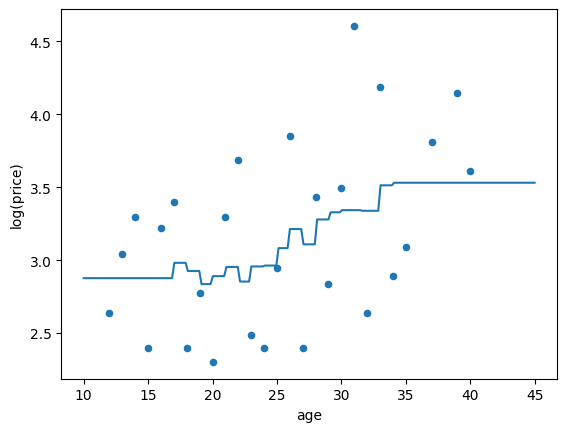

In [116]:
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X=X_train, y=y_train)

# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=200)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the predictions.
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

<AxesSubplot:xlabel='age', ylabel='log(price)'>

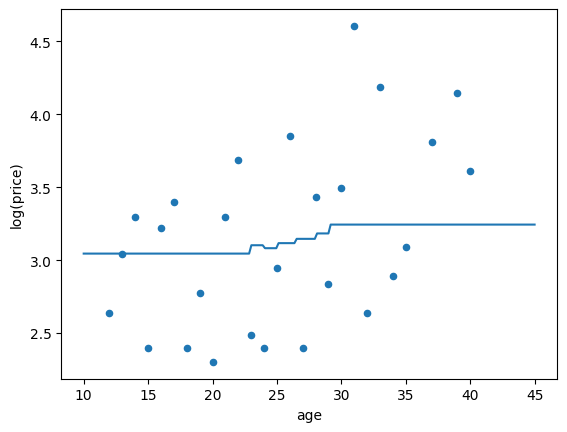

In [117]:
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=20)
model.fit(X=X_train, y=y_train)

# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=200)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the predictions.
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

2\. Using the Ames housing data set (AmesHousing.txt ), fit a $k$-nearest neighbors model that predicts the price of a home using square footage, number of bedrooms (**Bedroom AbvGr**), number of full bathrooms (**Full Bath**), and number of half bathrooms (**Half Bath**). Then, use your fitted model to predict the price of a home that is 1500 square feet, with 3 bedrooms, 2 full baths, and 1 half bath.

In [123]:
ames_df = pd.read_csv("AmesHousing.txt", sep='\t', index_col="Order")
#ames_df.head()
ames_train = ames_df.loc[:2344].copy()
ames_test = ames_df.loc[2345:].copy()

# Log transform the target.
ames_train["log(SalePrice)"] = np.log(ames_train["SalePrice"])
ames_train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,log(SalePrice)
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2010,WD,Normal,215000,12.278393
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000,11.561716
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000,12.055250
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,244000,12.404924
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900,12.154253


In [124]:
X_train = ames_train[["Bedroom AbvGr", "Full Bath", "Half Bath", "Gr Liv Area"]]
y_train = ames_train["SalePrice"]

home = pd.DataFrame({
    'Bedroom AbvGr' : [3],
    'Full Bath' : [2],
    'Half Bath' : [1],
    'Gr Liv Area' : [1500],
})

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=5)
model.fit(
    X=ames_train[["Bedroom AbvGr", "Full Bath", "Half Bath", "Gr Liv Area"]],
    y=ames_train["SalePrice"]
)

# Make predictions at those feature values.
model.predict(
    X = ames_test[["Bedroom AbvGr", "Full Bath", "Half Bath", "Gr Liv Area"]]
)

array([267400. , 195280. , 140760. , 234415.2, 264222. , 221100. ,
       328200. , 214250. , 124140. , 227700. , 229080. , 136900. ,
       187690. , 177380. , 140760. , 131740. , 113300. , 124880. ,
       121000. , 272003.4,  88250. , 148400. , 105080. , 122100. ,
       127340. , 127340. , 116400. ,  88250. , 105080. , 130100. ,
       146160. , 114540. , 140000. , 156880. , 223900. , 271317.4,
       259629. , 209400. , 234750. , 159980. , 229564.2, 222220. ,
       183280. , 327800. , 186280. , 253100. , 222500. , 231156. ,
       235500. , 292450. , 237900. , 241498.4, 205100. , 209200. ,
       252465.8, 209200. , 335412.2, 228100. , 201560. , 169820. ,
       218487.2, 151246.6, 151246.6, 227442.6, 165790. , 158500. ,
       132928.2, 156880. , 197315. , 174036. , 212272. , 188650. ,
       156880. , 200280. , 197315. , 169820. , 188300. , 181180. ,
       170680. , 165000. , 173640. , 150057.4, 113100. , 199726.4,
       205340. , 218499.8, 201800. , 157260. , 169986.4, 19683

In [126]:
model.predict(home)

array([184899.8])

3\. You would like to predict how much a male diner will tip on a bill of \\$40.00 on a Sunday. Build a $k$-nearest neighbors model to answer this question, using the tips data (tips.csv ) as your training data.

In [143]:
tips_df = pd.read_csv("tips.csv")

tips_df['day'] = tips_df['day'].replace("Sun" , '7').replace("Sat" , '1').replace("Fri" , '5').replace("Thu" , '4').replace("Wed" , '3').replace("Tue" , '2').replace("Mon" , '1').astype(float)

tips_df['sex'] = tips_df['sex'].replace("M" , '1').replace("F" , '2').astype(float)

tips_train = tips_df.loc[:200].copy()
tips_test = tips_df.loc[201:].copy()

# Log transform the target.
#tips_train["tip"] = np.log(tips_train["tip"])
tips_train.head()

,obs,totbill,tip,sex,smoker,day,time,size
0,1,16.99,1.01,2.0,No,7.0,Night,2
1,2,10.34,1.66,1.0,No,7.0,Night,3
2,3,21.01,3.50,1.0,No,7.0,Night,3
3,4,23.68,3.31,1.0,No,7.0,Night,2
4,5,24.59,3.61,2.0,No,7.0,Night,4


In [144]:
X_train = tips_train[["totbill", "day", "sex"]]
y_train = tips_train["tip"]

z = pd.DataFrame({
    'totbill' : [40],
    'day' : [7],
    'sex' : [1],
})

# Fit k-nearest neighbors
model = KNeighborsRegressor(n_neighbors=5)
model.fit(
    X=tips_train[["totbill", "day", "sex"]],
    y=tips_train["tip"]
)

# Make predictions at those feature values.
model.predict(
    X = tips_test[["totbill", "day", "sex"]]
)

array([2.214, 2.15 , 3.5  , 3.204, 3.5  , 3.506, 5.096, 3.574, 2.394,
       3.28 , 3.506, 5.846, 2.6  , 3.298, 2.394, 3.298, 1.792, 1.428,
       3.28 , 1.962, 2.19 , 1.534, 2.726, 1.9  , 2.726, 1.966, 3.156,
       2.194, 3.532, 4.134, 2.226, 1.792, 1.72 , 2.226, 1.658, 1.946,
       5.214, 5.49 , 3.28 , 3.786, 3.762, 3.082, 2.86 ])

In [145]:
model.predict(z)

array([4.346])